# Exploring data for fitting professional matches

Fairlay provides betting opportunities for lower tier leagues involving teams that are probably categorised as *professional* as opposed to *premium* in Datdota. The purpose of this notebook is to check the prospects and requirements of performing fitting and prediction on these non-premium tournament/league matches.

## Setup

In [11]:
import os
if 'src' not in os.listdir():
    os.chdir("..")

In [392]:
import gzip
import json
import pickle

import numpy as np
import pandas as pd

from src import load
import src.models.gp
import src.stats
import src.statics

In [73]:
import importlib
importlib.reload(src.models.gp)

<module 'src.models.gp' from '/Users/yl3/github/dota2/src/models/gp.py'>

In [3]:
pd.set_option('max_rows', 6)
pd.set_option('max_columns', 50)

## Load data

### Fairlay odds

In [31]:
with open('data/external/dota2_markets.20190831.pkl', 'rb') as fh:
    fl = pickle.load(fh)

In [478]:
fl_f = fl.copy()

# Only keep individual maps.
fl_f = fl_f.loc[fl_f.dota_market_type == 'map']

# For each Fairlay market, only keep the earliest odds.
fl_f = (fl_f.grou pby(['ID', 'wager_type', 'RunnerName'])
        .apply(lambda grp: grp.sort_values('LastSoftCh').iloc[0]))

# Remove TI9 matches
fl_f = fl_f.loc[fl_f.Comp != 'Dota 2 - The International']

fl_f

Comp  \
ID           wager_type RunnerName                                                     
177105530100 against    2Be Continued Esports  Dota 2 - Gold Occupation Invitational   
             on         2Be Continued Esports  Dota 2 - Gold Occupation Invitational   
177105530185 against    2Be Continued Esports  Dota 2 - Gold Occupation Invitational   
...                                                                              ...   
178683649722 on         LFS.cn                 Dota 2 - Gold Occupation Invitational   
178683649822 against    LFS.cn                 Dota 2 - Gold Occupation Invitational   
             on         LFS.cn                 Dota 2 - Gold Occupation Invitational   

                                                                        Title  \
ID           wager_type RunnerName                                              
177105530100 against    2Be Continued Esports  2Be Continued Esports vs. WOLF   
             on         2Be Continued Esports  2Be Continued Esports vs. WOLF   
177105530185 against    2Be Continued Esports  2Be Continued Esports vs. WOLF   
...                                                                       ...   
178683649722 on         LFS.cn                       LFS.cn vs. Five Brothers   
178683649822 against    LFS.cn                       LFS.cn vs. Five Brothers   
             on         LFS.cn                       LFS.cn vs. Five Brothers   

                                                 Descr dota_market_type  \
ID           wager_type RunnerName                                        
177105530100 against    2Be Continued Esports  1st Map              map   
             on         2Be Continued Esports  1st Map              map   
177105530185 against    2Be Continued Esports  2nd Map              map   
...                                                ...              ...   
178683649722 on         LFS.cn                 1st Map              map   
178683649822 against    LFS.cn                 2nd Map              map   
             on         LFS.cn                 2nd Map              map   

                                                             LastSoftCh  \
ID           wager_type RunnerName                                        
177105530100 against    2Be Continued Esports 2019-08-12 21:27:11-04:00   
             on         2Be Continued Esports 2019-08-12 21:27:11-04:00   
177105530185 against    2Be Continued Esports 2019-08-12 22:51:18-04:00   
...                                                                 ...   
178683649722 on         LFS.cn                2019-08-31 01:53:59-04:00   
178683649822 against    LFS.cn                2019-08-31 01:53:59-04:00   
             on         LFS.cn                2019-08-31 01:53:59-04:00   

                                                                  ClosD  \
ID           wager_type RunnerName                                        
177105530100 against    2Be Continued Esports 2019-08-13 02:58:02-04:00   
             on         2Be Continued Esports 2019-08-13 02:58:02-04:00   
177105530185 against    2Be Continued Esports 2019-08-13 02:58:02-04:00   
...                                                                 ...   
178683649722 on         LFS.cn                2019-08-31 04:59:09-04:00   
178683649822 against    LFS.cn                2019-08-31 04:59:09-04:00   
             on         LFS.cn                2019-08-31 04:59:09-04:00   

                                              wager_type  \
ID           wager_type RunnerName                         
177105530100 against    2Be Continued Esports    against   
             on         2Be Continued Esports         on   
177105530185 against    2Be Continued Esports    against   
...                                                  ...   
178683649722 on         LFS.cn                        on   
178683649822 against    LFS.cn                   against   
             on         LFS.cn                   

#### Team frequencies

In [487]:
fl_f_teams = fl_f.Title.str.split(' vs. ', expand=True)
fl_f_teams[0] = src.statics.fairlay_team_tr(fl_f_teams[0])
fl_f_teams[1] = src.statics.fairlay_team_tr(fl_f_teams[1])
print(pd.concat([fl_f_teams[0], fl_f_teams[1]]).value_counts().sort_index()
      .to_string())

2Be.Dota2                10
Alter Ego                 4
Antrophy                  4
Athletico                 4
BOOM ID                   4
Dark Sided                2
Five Brothers            20
Flashpoint Gaming         6
FlyToMoon                38
FrozenDawn               10
Hans Pro Gaming           6
Hippomaniacs             20
LFS.cn                    8
Look For Sponsors        12
Neon Esports             16
PG.Barracx                4
PG.Orca                   6
Pavaga Junior            10
Resurgence               12
Shutdown Esports Club    10
TRIDENT                   2
Team Aspirations         12
Team Drinking            10
Team EVOS                 4
Team Oracle               4
Team Space               16
The Prime NND             4
VG.Sunrise               20
Vega Squadron            28
WOLF                     10
WOLF.cn                   4
WOLF.dota                 8
ZEN9                      4


### Datdota match data

In [450]:
importlib.reload(src.load)

<module 'src.load' from '/Users/yl3/github/dota2/src/load.py'>

In [451]:
with gzip.open('data/raw/premium_matches.2019-08-31.json.gz', 'rb') as fh:
    premium_matches = load.matches_json_to_df(json.load(fh)['data'])
    prm_m = load.MatchDF(premium_matches)
with gzip.open('data/raw/professional_matches.2019-08-31.json.gz', 'rb') \
        as fh:
    professional_matches = load.matches_json_to_df(json.load(fh)['data'])
    prof_m = load.MatchDF(professional_matches)
with gzip.open('data/raw/semipro_matches.2019-08-31.json.gz', 'rb') \
        as fh:
    semipro_matches = load.matches_json_to_df(json.load(fh)['data'])
    semiprof_m = load.MatchDF(semipro_matches)

## Side track: test class for querying MatchDF matches. 

In [105]:
prm_m.df.loc[prm_m.df.radiant_name.isin(['TNC Predator', 'Vici Gaming'])
             & prm_m.df.dire_name.isin(['TNC Predator', 'Vici Gaming'])]

,startDate,league_name,radiant_name,dire_name,radiantVictory,radiant_nicknames,dire_nicknames,seriesId,duration,radiant_valveId,radiant_players,dire_valveId,dire_players,league_id,startTimestamp,series_start_time,match_i_in_series
matchId,,,,,,,,,,,,,,,,,
3810442630,2018-04-01 04:00:22,Dota 2 Asia Championships 2018,TNC Predator,Vici Gaming,True,"[Raven, TIMS, Armel, Kuku, Sam H]","[old LaNm, Ori, Fenrir, old eLeVeN, Paparazi]",-3810442630,1941,2108395,"[132309493, 155494381, 164532005, 184950344, 1...",726228,"[89423756, 107803494, 113800818, 134276083, 13...",9643,1522555222000,1522555222000,0
3815594091,2018-04-04 09:29:44,Dota 2 Asia Championships 2018,TNC Predator,Vici Gaming,True,"[Raven, TIMS, Armel, Kuku, Sam H]","[old LaNm, Ori, Fenrir, old eLeVeN, Paparazi]",212287,1926,2108395,"[132309493, 155494381, 164532005, 184950344, 1...",726228,"[89423756, 107803494, 113800818, 134276083, 13...",9643,1522834184000,1522834184000,0
3815664057,2018-04-04 10:31:23,Dota 2 Asia Championships 2018,Vici Gaming,TNC Predator,True,"[old LaNm, Ori, Fenrir, old eLeVeN, Paparazi]","[Raven, TIMS, Armel, Kuku, Sam H]",212287,2818,726228,"[89423756, 107803494, 113800818, 134276083, 13...",2108395,"[132309493, 155494381, 164532005, 184950344, 1...",9643,1522837883000,1522834184000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976922218,2019-08-20 05:33:15,The International 2019,TNC Predator,Vici Gaming,True,"[Gabbi, TIMS, Armel, Eyyou, Kuku]","[Ori, Paparazi, Yang, Dy, Fade]",359608,4602,2108395,"[152545459, 155494381, 164532005, 173476224, 1...",726228,"[107803494, 137193239, 139937922, 143693439, 1...",10749,1566279195000,1566279195000,0
4977018128,2019-08-20 07:20:47,The International 2019,TNC Predator,Vici Gaming,False,"[Gabbi, TIMS, Armel, Eyyou, Kuku]","[Ori, Paparazi, Yang, Dy, Fade]",359608,3673,2108395,"[152545459, 155494381, 164532005, 173476224, 1...",726228,"[107803494, 137193239, 139937922, 143693439, 1...",10749,1566285647000,1566279195000,1
4977114097,2019-08-20 08:50:26,The International 2019,TNC Predator,Vici Gaming,False,"[Gabbi, TIMS, Armel, Eyyou, Kuku]","[Ori, Paparazi, Yang, Dy, Fade]",359608,2082,2108395,"[152545459, 155494381, 164532005, 173476224, 1...",726228,"[107803494, 137193239, 139937922, 143693439, 1...",10749,1566291026000,1566279195000,2


### `MatchupDict.from_match_df()`

In [121]:
temp = load.MatchupDict.from_match_df(prm_m)

In [122]:
temp.query('TNC Predator', 'Vici Gaming', 0, '2018-04-01 04:00:22')

(3810442630, False)

In [102]:
temp.query('Vici Gaming', 'TNC Predator', 0, '2018-04-01 04:00:22')

(3810442630, True)

In [107]:
display(temp.query('TNC Predator', 'Vici Gaming', 0, '2018-03-01 04:00:22'))
display(temp.query('TNC Predator', 'Vici Gaming', 0, '2018-04-02 04:00:22'))

(3810442630, False)

(3810442630, False)

### `MatchDF.query_maps()`

In [195]:
import importlib
importlib.reload(src.models.gp)
importlib.reload(load)

<module 'src.load' from '/Users/yl3/github/dota2/src/load.py'>

In [196]:
with gzip.open('data/raw/premium_matches.2019-08-31.json.gz', 'rb') as fh:
    premium_matches = load.matches_json_to_df(json.load(fh)['data'])
    prm_m = load.MatchDF(premium_matches)

> /Users/yl3/github/dota2/src/load.py(268)_validate_matches_df()
-> if not expected_columns <= set(matches_df.columns):
(Pdb) n
--Return--
> /Users/yl3/github/dota2/src/load.py(268)_validate_matches_df()->None
-> if not expected_columns <= set(matches_df.columns):
(Pdb) n
> /Users/yl3/github/dota2/src/load.py(196)__init__()
-> self.df = matches_df
(Pdb) q


BdbQuit: 

In [193]:
# Expected match ID: 3815664057
prm_m.query_maps('Vici Gaming', 'TNC Predator', 1, '2018-04-04 10:31:23')

,,,,matchId,startDate,league_name,radiant_name,dire_name,radiantVictory,radiant_nicknames,dire_nicknames,seriesId,duration,radiant_valveId,radiant_players,dire_valveId,dire_players,league_id,startTimestamp,series_start_time,match_i_in_series,qry_flipped
qry_team1,qry_team2,qry_map_i,qry_time,,,,,,,,,,,,,,,,,,,
Vici Gaming,TNC Predator,1,2018-04-04 10:31:23,3815664057,2018-04-04 10:31:23,Dota 2 Asia Championships 2018,Vici Gaming,TNC Predator,True,"[old LaNm, Ori, Fenrir, old eLeVeN, Paparazi]","[Raven, TIMS, Armel, Kuku, Sam H]",212287,2818,726228,"[89423756, 107803494, 113800818, 134276083, 13...",2108395,"[132309493, 155494381, 164532005, 184950344, 1...",9643,1522837883000,1522834184000,1,True


In [194]:
prm_m.query_maps('TNC Predator', 'Vici Gaming', [0, 0, 1],
                 ['2018-04-01 04:00:22', '2018-04-04 04:00:22',
                  '2018-04-04 10:31:23'])

matchId  \
qry_team1    qry_team2   qry_map_i qry_time                          
TNC Predator Vici Gaming 0         2018-04-01 04:00:22  3810442630   
                                   2018-04-04 04:00:22  3815594091   
                         1         2018-04-04 10:31:23  3815664057   

                                                                 startDate  \
qry_team1    qry_team2   qry_map_i qry_time                                  
TNC Predator Vici Gaming 0         2018-04-01 04:00:22 2018-04-01 04:00:22   
                                   2018-04-04 04:00:22 2018-04-04 09:29:44   
                         1         2018-04-04 10:31:23 2018-04-04 10:31:23   

                                                                           league_name  \
qry_team1    qry_team2   qry_map_i qry_time                                              
TNC Predator Vici Gaming 0         2018-04-01 04:00:22  Dota 2 Asia Championships 2018   
                                   2018-04-04 04:00:22  Dota 2 Asia Championships 2018   
                         1         2018-04-04 10:31:23  Dota 2 Asia Championships 2018   

                                                        radiant_name  \
qry_team1    qry_team2   qry_map_i qry_time                            
TNC Predator Vici Gaming 0         2018-04-01 04:00:22  TNC Predator   
                                   2018-04-04 04:00:22  TNC Predator   
                         1         2018-04-04 10:31:23   Vici Gaming   

                                                           dire_name  \
qry_team1    qry_team2   qry_map_i qry_time                            
TNC Predator Vici Gaming 0         2018-04-01 04:00:22   Vici Gaming   
                                   2018-04-04 04:00:22   Vici Gaming   
                         1         2018-04-04 10:31:23  TNC Predator   

                                                        radiantVictory  \
qry_team1    qry_team2   qry_map_i qry_time                              
TNC Predator Vici Gaming 0         2018-04-01 04:00:22            True   
                                   2018-04-04 04:00:22            True   
                         1         2018-04-04 10:31:23            True   

                                                                                    radiant_nicknames  \
qry_team1    qry_team2   qry_map_i qry_time                                                             
TNC Predator Vici Gaming 0         2018-04-01 04:00:22              [Raven, TIMS, Armel, Kuku, Sam H]   
                                   2018-04-04 04:00:22              [Raven, TIMS, Armel, Kuku, Sam H]   
                         1         2018-04-04 10:31:23  [old LaNm, Ori, Fenrir, old eLeVeN, Paparazi]   

                                                                                       dire_nicknames  \
qry_team1    qry_team2   qry_map_i qry_time                                                             
TNC Predator Vici Gaming 0         2018-04-01 04:00:22  [old LaNm, Ori, Fenrir, old eLeVeN, Paparazi]   
                                   2018-04-04 04:00:22  [old LaNm, Ori, Fenrir, old eLeVeN, Paparazi]   
                         1         2018-04-04 10:31:23              [Raven, TIMS, Armel, Kuku, Sam H]   

                                                           seriesId  duration  \
qry_team1    qry_team2   qry_map_i qry_time                                     
TNC Predator Vici Gaming 0         2018-04-01 04:00:22  -3810442630      1941   
                                   2018-04-04 04:00:22       212287      1926   
                         1         2018-04-04 10:31:23       212287      2818   

                                                        radiant_valveId  \
qry_team1    qry_team2   qry_map_i qry_time                               
TNC Predator Vici Gaming 0         2018-04-01 04:00:22          2108395   
                                   2018-04-04 04:00:22          2108395   
               

## How many of the Fairlay second tier matches are in Datdota?

### Match team names.

In [234]:
premium_match_teams = pd.concat([prm_m.df.radiant_name, prm_m.df.dire_name])
pro_match_teams = pd.concat([prof_m.df.radiant_name, prof_m.df.dire_name])
semipro_match_teams = pd.concat([semiprof_m.df.radiant_name,
                                 semiprof_m.df.dire_name])

semipro_match_teams.value_counts().sort_index()

                         3
"Shinda Sekai Sensen"    2
$tHe 5 KnIgHtS           2
                        ..
เสือคาบดาบ               2
เอาจริงละนะ              4
深圳Wolf.Z                 7
Length: 1187, dtype: int64

In [307]:
team_name = 'prime'

print("Premium")
print(premium_match_teams[premium_match_teams.str.contains(team_name, case=False)].value_counts().to_string())

print("Professional")
print(prof_match_teams[prof_match_teams.str.contains(team_name, case=False)].value_counts().to_string())

print("Semipro")
print(semipro_match_teams[semipro_match_teams.str.contains(team_name, case=False)].value_counts().to_string())

Premium
The Prime NND    8
The Prime        1
Professional
The Prime NND    2
Semipro
The Prime NND    47
The Prime         2


In [240]:
temp = fl_f_teams.unstack().str.lower().value_counts().sort_index()
in_premium = premium_match_teams.str.lower().value_counts().reindex(
    temp.index)
in_prof = prof_match_teams.str.lower().value_counts().reindex(
    temp.index)
in_semipro = semipro_match_teams.str.lower().value_counts().reindex(
    temp.index)
with pd.option_context('max_rows', 34):
    display(pd.DataFrame({'fairlay_count': temp, 'in_premium': in_premium,
                          'in_prof': in_prof, 'in_semipro': in_semipro}))

,fairlay_count,in_premium,in_prof,in_semipro
2be continued esports,5,NaN,NaN,NaN
alter ego,2,NaN,NaN,4.0
antrophy,2,NaN,NaN,NaN
athletico,2,NaN,NaN,NaN
boom id,2,130.0,6.0,22.0
dark sided,1,NaN,NaN,NaN
evos esports,2,NaN,NaN,NaN
five brothers,10,NaN,NaN,NaN
flashpoint gaming,3,NaN,NaN,NaN
flytomoon,19,21.0,30.0,NaN


## How long does it take to fit 10,000 matches?

Out of curiosity, how long would it take to fit all *premium* and *professional* matches at the same time?

### Baseline: with premium matches only.

In [376]:
premium_pro_model = src.models.gp.SkillsGPMAP(
    None,
    None,
    prm_m.players_mat,
    prm_m.df.startTimestamp,
    prm_m.df.radiantVictory,
    'exponential',
    {'scale': 1.25 * 365 * 24 * 60 * 60 * 1000},
    radi_prior_sd=3.0,
    logistic_scale=3.0)

In [377]:
premium_pro_model.fit()
premium_pro_model.fitted

     fun: -129099.62113051812
     jac: array([ 4.86648008e-05, -4.44571003e-05,  2.06406646e-08, ...,
        1.97465714e-05, -1.89823967e-05, -2.70741711e-06])
 message: 'Optimization terminated successfully.'
    nfev: 16
    nhev: 13471
     nit: 15
    njev: 30
  status: 0
 success: True
       x: array([0.14178653, 0.14181707, 0.1266765 , ..., 0.04609887, 0.04558296,
       0.49055114])

### Now with combined premium and professional matches.

In [378]:
combined_matches = load.MatchDF(
    pd.concat([premium_matches, professional_matches]))
combined_matches.df

,startDate,league_name,radiant_name,dire_name,radiantVictory,radiant_nicknames,dire_nicknames,seriesId,duration,radiant_valveId,radiant_players,dire_valveId,dire_players,league_id,startTimestamp,series_start_time,match_i_in_series
matchId,,,,,,,,,,,,,,,,,
2485112789,2016-07-06 05:13:59,Dota 2 Professional League,CDEC.Avengers,trg,True,"[Xi, 876, June, Monet, Flyby]","[替补.777, waslost, DaShiSayNo, Pala, Soolu]",76520,1069,2643401,"[89246836, 103729052, 138885864, 148215639, 18...",2860414,"[108454598, 114776055, 129771227, 137944511, 2...",4693,1467782039000,1467782039000,0
2485119809,2016-07-06 05:18:56,Dota 2 Professional League,Avalon_Club,Newbee.Young,False,"[sjl, Speed!, Unknown, MOONLIGHT, egg]","[Key, JiaJia, 2Lei, Le, Sccc]",76519,1741,2414095,"[110090274, 113055496, 145692178, 162324892, 1...",1951061,"[89296893, 103275898, 117199412, 135726105, 14...",4693,1467782336000,1467782336000,0
2485180059,2016-07-06 06:00:00,Nanyang Championships Season 2,the wings gaming,Team Empire,True,"[跳刀跳刀丶, iceice, y`Maxine, Faith_bian, shadow]","[Scandal, AfterLife, Miposhka, RAMZES666, KingR]",76524,2686,1836806,"[101586543, 102644565, 111114687, 118134220, 1...",46,"[86750262, 86785083, 113331514, 132851371, 182...",4660,1467784800000,1467784800000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4986260666,2019-08-25 09:51:46,The International 2019,Team Liquid,OG,False,"[MinD_ContRoL, KuroKy, w33, GH, Miracle]","[n0tail, JerAx, 7ckngMad, topson, ana]",360940,1945,2163,"[34505203, 82262664, 86700461, 101356886, 1052...",2586976,"[19672354, 26771994, 88271237, 94054712, 31136...",10749,1566726706000,1566721992000,1
4986362254,2019-08-25 10:54:19,The International 2019,Team Liquid,OG,False,"[MinD_ContRoL, KuroKy, w33, GH, Miracle]","[n0tail, JerAx, 7ckngMad, topson, ana]",360940,1403,2163,"[34505203, 82262664, 86700461, 101356886, 1052...",2586976,"[19672354, 26771994, 88271237, 94054712, 31136...",10749,1566730459000,1566721992000,2
4986461644,2019-08-25 11:50:17,The International 2019,OG,Team Liquid,True,"[n0tail, JerAx, 7ckngMad, topson, ana]","[MinD_ContRoL, KuroKy, w33, GH, Miracle]",360940,1474,2586976,"[19672354, 26771994, 88271237, 94054712, 31136...",2163,"[34505203, 82262664, 86700461, 101356886, 1052...",10749,1566733817000,1566721992000,3


### Fit.

In [386]:
premium_pro_model = src.models.gp.SkillsGPMAP(
    None,
    None,
    combined_matches.players_mat,
    combined_matches.df.startTimestamp,
    combined_matches.df.radiantVictory,
    'exponential',
    {'scale': 1.25 * 365 * 24 * 60 * 60 * 1000},
    radi_prior_sd=3.0,
    logistic_scale=3.0)

In [387]:
if premium_pro_model.fitted is None:
    premium_pro_model.fit()
premium_pro_model.fitted

     fun: -249677.2060008297
     jac: array([ 1.33086819e-07,  1.06096102e-06,  3.14681477e-08, ...,
        1.34502099e-05, -1.31528443e-05,  8.34831632e-07])
 message: 'Optimization terminated successfully.'
    nfev: 17
    nhev: 16594
     nit: 16
    njev: 32
  status: 0
 success: True
       x: array([0.11543125, 0.11513527, 0.11520785, ..., 0.05592186, 0.05543816,
       0.31739084])

### Explore back-predictions.

In [388]:
match_pred = src.stats.MatchPred(
    combined_matches,
    premium_pro_model.fitted_pred_df(),
    3.0,
    premium_pro_model.fitted_skills_mat())

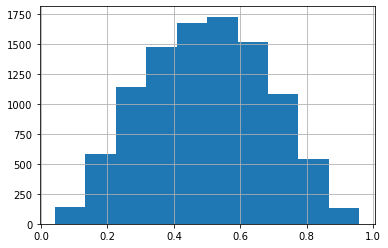

In [389]:
match_pred.df.pred_win_prob_unknown_side.hist()

In [390]:
with pd.option_context('max_rows', 50):
    idx = abs(match_pred.df.startDate - pd.to_datetime('2019-08-24 0:19:15-04:00').tz_convert(None)).idxmin()
    display(match_pred.df.loc[idx])

startDate                                                   2019-08-24 04:19:15
league_name                                              The International 2019
radiant_name                                                                 OG
dire_name                                                               PSG.LGD
radiantVictory                                                            False
radiant_nicknames                        [n0tail, JerAx, 7ckngMad, topson, ana]
dire_nicknames                              [xNova, Chalice, fy, Somnus丶M, Ame]
seriesId                                                                 360528
duration                                                                   2687
radiant_valveId                                                         2586976
radiant_players               [19672354, 26771994, 88271237, 94054712, 31136...
dire_valveId                                                                 15
dire_players                  [94296097,

## How many Fairlay 2nd tier matches can we map with premium matches?

In [404]:
fl_f.head(2)

,Comp,Title,Descr,dota_market_type,LastSoftCh,ClosD,wager_type,RunnerName,handicap,odds,odds_c,amount,winp,winp_c,RunnerVolMatched,CatID,SettlD,Status,_Type,_Period,SettlT,Comm,Settler,ComRecip,MinVal,MaxVal,LastCh,LogBugs,Pop,Margin,RunnerVisDelay,RunnerRedA,OrdBStr_S,MarketType,MarketPeriod,MarketCat
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
177105530100,Dota 2 - Gold Occupation Invitational,2Be Continued Esports vs. WOLF,1st Map,map,2019-08-12 21:27:11-04:00,2019-08-13 02:58:02-04:00,against,2Be Continued Esports,0.0,1.98,1.978,9.11,0.4950,0.4944,0.0,32,2019-08-13 03:58:02-04:00,0,0,0,0,0.0025,"{'1': True, '777889': True, '777555': True}","{'1011849': 0.5, '1013506': 0.5}",0.0,0.0,2019-08-12 15:58:50-04:00,,0.0,106.833,6000,0.0,0,MONEYLINE,UNDEFINED,eSports
177105530185,Dota 2 - Gold Occupation Invitational,2Be Continued Esports vs. WOLF,2nd Map,map,2019-08-12 22:51:18-04:00,2019-08-13 02:58:02-04:00,against,2Be Continued Esports,0.0,2.03,2.027,10.11,0.5074,0.5067,0.0,32,2019-08-13 03:58:02-04:00,0,0,0,0,0.0025,"{'1': True, '777889': True, '777555': True}","{'1011849': 0.5, '1013506': 0.5}",0.0,0.0,2019-08-12 15:58:50-04:00,,0.0,107.101,6000,0.0,0,MONEYLINE,UNDEFINED,eSports


### Query *premium* matches.

In [495]:
map_i = fl_f.Descr.str[0].astype(int) - 1
matched = (prm_m.query_maps(fl_f_teams[0], fl_f_teams[1], map_i, fl_f.ClosD)
           .dropna())
with pd.option_context('max_rows', 12):
    display(matched.shape)
    display(matched)

(12, 19)

matchId  \
qry_team1     qry_team2    qry_map_i qry_time                                  
Vega Squadron Hippomaniacs 0         2019-08-14 02:58:43-04:00  4.253154e+09   
                                     2019-08-14 02:58:43-04:00  4.253154e+09   
                           1         2019-08-14 02:58:43-04:00  4.253043e+09   
                                     2019-08-14 02:58:43-04:00  4.253043e+09   
                           0         2019-08-13 11:49:59-04:00  4.253154e+09   
                                     2019-08-13 11:49:59-04:00  4.253154e+09   
                           1         2019-08-13 13:29:23-04:00  4.253043e+09   
                                     2019-08-13 13:29:23-04:00  4.253043e+09   
              FlyToMoon    0         2019-08-15 02:59:00-04:00  4.889982e+09   
                                     2019-08-15 02:59:00-04:00  4.889982e+09   
                                     2019-08-14 13:28:25-04:00  4.889982e+09   
                                     2019-08-14 13:28:25-04:00  4.889982e+09   

                                                                         startDate  \
qry_team1     qry_team2    qry_map_i qry_time                                        
Vega Squadron Hippomaniacs 0         2019-08-14 02:58:43-04:00 2018-12-03 18:53:03   
                                     2019-08-14 02:58:43-04:00 2018-12-03 18:53:03   
                           1         2019-08-14 02:58:43-04:00 2018-12-03 17:22:14   
                                     2019-08-14 02:58:43-04:00 2018-12-03 17:22:14   
                           0         2019-08-13 11:49:59-04:00 2018-12-03 18:53:03   
                                     2019-08-13 11:49:59-04:00 2018-12-03 18:53:03   
                           1         2019-08-13 13:29:23-04:00 2018-12-03 17:22:14   
                                     2019-08-13 13:29:23-04:00 2018-12-03 17:22:14   
              FlyToMoon    0         2019-08-15 02:59:00-04:00 2019-07-07 15:23:11   
                                     2019-08-15 02:59:00-04:00 2019-07-07 15:23:11   
                                     2019-08-14 13:28:25-04:00 2019-07-07 15:23:11   
                                     2019-08-14 13:28:25-04:00 2019-07-07 15:23:11   

                                                                             league_name  \
qry_team1     qry_team2    qry_map_i qry_time                                              
Vega Squadron Hippomaniacs 0         2019-08-14 02:58:43-04:00  The Bucharest Minor 2019   
                                     2019-08-14 02:58:43-04:00  The Bucharest Minor 2019   
                           1         2019-08-14 02:58:43-04:00  The Bucharest Minor 2019   
                                     2019-08-14 02:58:43-04:00  The Bucharest Minor 2019   
                           0         2019-08-13 11:49:59-04:00  The Bucharest Minor 2019   
                                     2019-08-13 11:49:59-04:00  The Bucharest Minor 2019   
                           1         2019-08-13 13:29:23-04:00  The Bucharest Minor 2019   
                                     2019-08-13 13:29:23-04:00  The Bucharest Minor 2019   
              FlyToMoon    0         2019-08-15 02:59:00-04:00    The International 2019   
                                     2019-08-15 02:59:00-04:00    The International 2019   
                                     2019-08-14 13:28:25-04:00    The International 2019   
                                     2019-08-14 13:28:25-04:00    The International 2019   

                                                                 radiant_name  \
qry_team1     qry_team2    qry_map_i qry_time                                   
Vega Squadron Hippomaniacs 0         2019-08-14 02:58:43-04:00   Hippomaniacs   
                                     2019-08-14 02:58:43-04:00   Hippomaniacs   
                           1         2019-08-14 02:58:43-04:00   Hippomaniacs   
                                     2019-08-14 0

### Query *professional* matches.

In [501]:
map_i = fl_f.Descr.str[0].astype(int) - 1
matched = (prof_m.query_maps(fl_f_teams[0], fl_f_teams[1], map_i, fl_f.ClosD))
with pd.option_context('max_rows', 42):
    display(matched.shape)
    display(matched.dropna())

(166, 19)

matchId  \
qry_team1     qry_team2     qry_map_i qry_time                                  
Vega Squadron Hippomaniacs  0         2019-08-14 02:58:43-04:00  4.965122e+09   
                                      2019-08-14 02:58:43-04:00  4.965122e+09   
                            1         2019-08-14 02:58:43-04:00  4.965220e+09   
                                      2019-08-14 02:58:43-04:00  4.965220e+09   
FlyToMoon     Pavaga Junior 0         2019-08-14 02:58:36-04:00  4.965389e+09   
                                      2019-08-14 02:58:36-04:00  4.965389e+09   
                            1         2019-08-14 02:58:36-04:00  4.965476e+09   
                                      2019-08-14 02:58:36-04:00  4.965476e+09   
                            2         2019-08-14 02:58:36-04:00  4.940382e+09   
                                      2019-08-14 02:58:36-04:00  4.940382e+09   
Vega Squadron Hippomaniacs  0         2019-08-13 11:49:59-04:00  4.965122e+09   
                                      2019-08-13 11:49:59-04:00  4.965122e+09   
                            1         2019-08-13 13:29:23-04:00  4.965220e+09   
                                      2019-08-13 13:29:23-04:00  4.965220e+09   
FlyToMoon     Pavaga Junior 0         2019-08-13 14:51:04-04:00  4.965389e+09   
                                      2019-08-13 14:51:04-04:00  4.965389e+09   
                            1         2019-08-13 15:50:19-04:00  4.965476e+09   
                                      2019-08-13 15:50:19-04:00  4.965476e+09   
              Hippomaniacs  0         2019-08-15 02:58:03-04:00  4.966641e+09   
                                      2019-08-15 02:58:03-04:00  4.966641e+09   
                            1         2019-08-15 02:58:03-04:00  4.966782e+09   
                                      2019-08-15 02:58:03-04:00  4.966782e+09   
                            2         2019-08-15 02:58:03-04:00  4.963745e+09   
                                      2019-08-15 02:58:03-04:00  4.963745e+09   
                            0         2019-08-14 10:29:46-04:00  4.966641e+09   
                                      2019-08-14 10:29:46-04:00  4.966641e+09   
                            1         2019-08-14 10:50:49-04:00  4.966782e+09   
                                      2019-08-14 10:50:49-04:00  4.966782e+09   
Vega Squadron FlyToMoon     0         2019-08-15 02:59:00-04:00  4.967016e+09   
                                      2019-08-15 02:59:00-04:00  4.967016e+09   
                            1         2019-08-15 02:59:00-04:00  4.967119e+09   
                                      2019-08-15 02:59:00-04:00  4.967119e+09   
                            2         2019-08-15 02:59:00-04:00  4.967218e+09   
                                      2019-08-15 02:59:00-04:00  4.967218e+09   
                            0         2019-08-14 13:28:25-04:00  4.967016e+09   
                                      2019-08-14 13:28:25-04:00  4.967016e+09   
                            1         2019-08-14 14:25:47-04:00  4.967119e+09   
                                      2019-08-14 14:25:47-04:00  4.967119e+09   
                            2         2019-08-14 13:51:48-04:00  4.967218e+09   
                                      2019-08-14 13:51:48-04:00  4.967218e+09   
                                      2019-08-14 14:56:12-04:00  4.967218e+09   
                                      2019-08-14 14:56:12-04:00  4.967218e+09   

                                                                          startDate  \
qry_team1     qry_team2     qry_map_i qry_time                                        
Vega Squadron Hippomaniacs  0         2019-08-14 02:58:43-04:00 2019-08-13 15:14:57   
                                      2019-08-14 02:58:43-04:00 2019-08-13 15:14:57   
                            1         2019-08-14 02:58:43-04:00 2019-08-13 16:08:49   
                                      2019-08-14 02:58:43-04:00 2019-0

In [499]:
fl_f.loc[matched.matchId.notna().values]

Comp  \
ID           wager_type RunnerName                              
177145016307 against    Vega Squadron  Dota 2 - LOOT.BET/DOTA   
             on         Vega Squadron  Dota 2 - LOOT.BET/DOTA   
177145016383 against    Vega Squadron  Dota 2 - LOOT.BET/DOTA   
...                                                       ...   
177268915565 on         Vega Squadron  Dota 2 - LOOT.BET/DOTA   
177272779490 against    Vega Squadron  Dota 2 - LOOT.BET/DOTA   
             on         Vega Squadron  Dota 2 - LOOT.BET/DOTA   

                                                                Title  \
ID           wager_type RunnerName                                      
177145016307 against    Vega Squadron  Vega Squadron vs. Hippomaniacs   
             on         Vega Squadron  Vega Squadron vs. Hippomaniacs   
177145016383 against    Vega Squadron  Vega Squadron vs. Hippomaniacs   
...                                                               ...   
177268915565 on         Vega Squadron     Vega Squadron vs. FlyToMoon   
177272779490 against    Vega Squadron     Vega Squadron vs. FlyTomoon   
             on         Vega Squadron     Vega Squadron vs. FlyTomoon   

                                         Descr dota_market_type  \
ID           wager_type RunnerName                                
177145016307 against    Vega Squadron  1st Map              map   
             on         Vega Squadron  1st Map              map   
177145016383 against    Vega Squadron  2nd Map              map   
...                                        ...              ...   
177268915565 on         Vega Squadron  3rd Map              map   
177272779490 against    Vega Squadron  3rd Map              map   
             on         Vega Squadron  3rd Map              map   

                                                     LastSoftCh  \
ID           wager_type RunnerName                                
177145016307 against    Vega Squadron 2019-08-13 07:14:56-04:00   
             on         Vega Squadron 2019-08-13 07:14:56-04:00   
177145016383 against    Vega Squadron 2019-08-13 03:03:20-04:00   
...                                                         ...   
177268915565 on         Vega Squadron 2019-08-14 13:30:04-04:00   
177272779490 against    Vega Squadron 2019-08-14 14:30:09-04:00   
             on         Vega Squadron 2019-08-14 14:30:09-04:00   

                                                          ClosD wager_type  \
ID           wager_type RunnerName                                           
177145016307 against    Vega Squadron 2019-08-14 02:58:43-04:00    against   
             on         Vega Squadron 2019-08-14 02:58:43-04:00         on   
177145016383 against    Vega Squadron 2019-08-14 02:58:43-04:00    against   
...                                                         ...        ...   
177268915565 on         Vega Squadron 2019-08-14 13:51:48-04:00         on   
177272779490 against    Vega Squadron 2019-08-14 14:56:12-04:00    against   
             on         Vega Squadron 2019-08-14 14:56:12-04:00         on   

                                          RunnerName  handicap   odds  odds_c  \
ID           wager_type RunnerName                                              
177145016307 against    Vega Squadron  Vega Squadron       0.0  1.980   1.978   
             on         Vega Squadron  Vega Squadron       0.0  1.769   1.767   
177145016383 against    Vega Squadron  Vega Squadron       0.0  2.089   2.087   
...                                              ...       ...    ...     ...   
177268915565 on         Vega Squadron  Vega Squadron       0.0  1.462   1.461   
177272779490 against    Vega Squadron  Vega Squadron       0.0  1.847   1.845   
             on         Vega Squadron  Vega Squadron       0.0  1.819   1.817   

                                       amount    winp  winp_c  \
ID           wager_type RunnerName                              
177145016307 against    Vega Squadron    9